In [111]:

import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import sys
import numpy as np
import tensorflow as tf
sys.path.append('c:/python310/lib/site-packages/tensorflow_privacy/')

from privacy.analysis import compute_dp_sgd_privacy


def clip_grad(grad, C):
    return grad/np.max([1, np.linalg.norm(grad)/C])

def add_grad_noise(grad, sigma, C):
    return grad + np.random.normal(0, sigma, grad.shape)

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]




In [112]:

def get_accuracy(x, y, w, b):
    scores = np.dot(x, w.T) + b
    probs = 1 / (1 + np.exp(-scores))
    y_pred = np.argmax(probs, axis=1)
    accuracy = np.mean(y_pred == np.argmax(y, axis=1))
    return accuracy

def compute_epsilon(batch_size, delta, sigma, iterations):
    eps = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
        n=60000,
        batch_size=batch_size,
        noise_multiplier=sigma,
        epochs=iterations,
        delta=delta)
    return eps[0]
    

def logistic_regression_sgd(X, y, learning_rate, num_epochs, batch_size, do_dp=False, C=0.5, sigma=0.5, delta=1e-5, track_acc=False):
    N, D = X.shape
    K = y.shape[1]
    w = np.zeros((K, D))
    b = np.zeros(K)
    
    test_accs = np.zeros(num_epochs+1)
    train_accs = np.zeros(num_epochs+1)
    epsilons = np.zeros(num_epochs+1)

    epoch = 0
    if track_acc:
        test_accs[epoch] = get_accuracy(x_test, y_test, w, b)
        train_accs[epoch] = get_accuracy(x_train, y_train, w, b)
    if do_dp:
        epsilons[epoch] = compute_epsilon(batch_size, delta, sigma, epoch+1)

    for epoch in range(num_epochs):
        # Shuffle the data
        perm = np.random.permutation(N)
        X = X[perm]
        y = y[perm]

        # Process the data in batches
        for i in range(0, N, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            # Forward pass
            scores = np.dot(X_batch, w.T) + b
            probs = 1 / (1 + np.exp(-scores))

            # Backward pass
            dscores = 1/batch_size * (probs - y_batch)
            grad_w = np.dot(dscores.T, X_batch)
            grad_b = np.sum(dscores, axis=0)

            if do_dp:
                grad_w = clip_grad(grad_w, C)
                grad_w = add_grad_noise(grad_w, sigma, C)
                grad_b = clip_grad(grad_b, C)
                grad_b = add_grad_noise(grad_b, sigma, C)

            # Update weights
            w -= learning_rate * grad_w
            b -= learning_rate * grad_b

        if track_acc:
            test_accs[epoch+1] = get_accuracy(x_test, y_test, w, b)
            train_accs[epoch+1] = get_accuracy(x_train, y_train, w, b)
        if do_dp:
            epsilons[epoch+1] = compute_epsilon(batch_size, delta, sigma, epoch+1)
    return w, b, epsilons, test_accs


In [113]:

sigmas = [0.6, 0.7, 0.8, 0.9, 1, 2, 5]
epsilons = []
testaccs = []
for s in sigmas:
    w, b, eps, testacc = logistic_regression_sgd(x_train, y_train, learning_rate=0.01,
                               num_epochs=50, batch_size=600, do_dp=True, track_acc=True, sigma=s)
    epsilons.append(eps)
    testaccs.append(testacc)

w,b,eps,testacc = logistic_regression_sgd(x_train, y_train, learning_rate=0.01,
                                 num_epochs=50, batch_size=600, do_dp=False, track_acc=True)
testaccs.append(testacc)


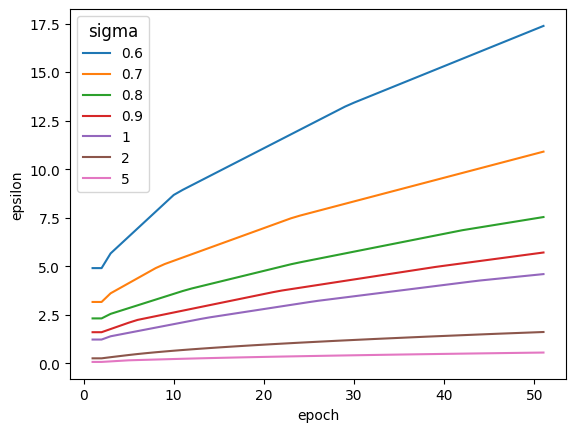

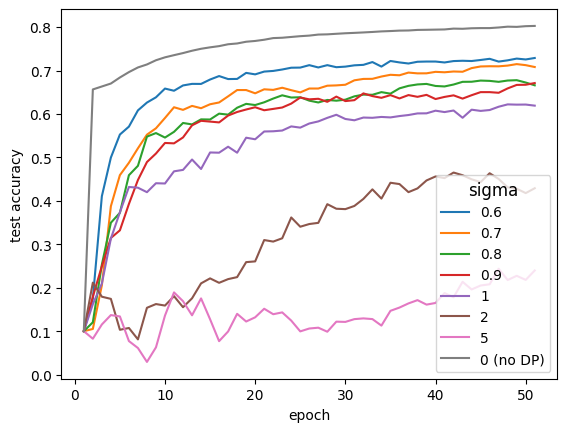

Accuracy: 0.8027


In [114]:
# plot epochs vs epsilon
for i in range(len(sigmas)):
    plt.plot(np.arange(1, 52), epsilons[i], label=sigmas[i])
plt.xlabel("epoch")
plt.ylabel("epsilon")
legend = plt.legend(sigmas)
legend.set_title('sigma', prop={'size': 12})
plt.show()

sigmas.append("0 (no DP)")
for i in range(len(sigmas)):
    plt.plot(np.arange(1, 52), testaccs[i], label=sigmas[i])
plt.xlabel("epoch")
plt.ylabel("test accuracy")
legend = plt.legend(sigmas)
legend.set_title('sigma', prop={'size': 12})
plt.show()


# Evaluate the model on the test set
accuracy = get_accuracy(x_test, y_test, w, b)
print(f"Accuracy: {accuracy:.4f}")


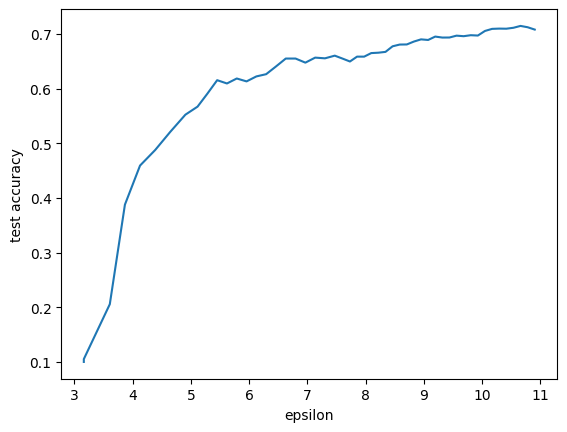

In [121]:
# plot accuracy vs epsilon, for the sigma=0.7 case
plt.plot(epsilons[1], testaccs[1])
plt.xlabel("epsilon")
plt.ylabel("test accuracy")
plt.show()


In [118]:
# print out last accuracy and epsilon for each sigma
for i in range(len(sigmas)-1):
    print("sigma: ", sigmas[i], "epsilon: ", epsilons[i][-1], "test accuracy: ", testaccs[i][-1])
print("sigma: ", sigmas[-1], "epsilon: ", "0", "test accuracy: ", testaccs[-1][-1])



sigma:  0.6 epsilon:  17.37944679902533 test accuracy:  0.7289
sigma:  0.7 epsilon:  10.904128188686727 test accuracy:  0.7081
sigma:  0.8 epsilon:  7.534835271613648 test accuracy:  0.666
sigma:  0.9 epsilon:  5.708473397854784 test accuracy:  0.6712
sigma:  1 epsilon:  4.596064547665558 test accuracy:  0.6192
sigma:  2 epsilon:  1.6131296313476402 test accuracy:  0.4291
sigma:  5 epsilon:  0.5550211437269066 test accuracy:  0.2398
sigma:  0 (no DP) epsilon:  0 test accuracy:  0.8027
